# Imports

## Mount Drive

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


## Python packages imports

In [2]:
!pip install --quiet tensorflow_io

     |████████████████████████████████| 24.1MB 124kB/s 
     |████████████████████████████████| 2.5MB 46.2MB/s 


In [3]:
import tensorflow as tf
import tensorflow_io as tfio

In [4]:
from sklearn.model_selection import train_test_split

In [5]:
from tensorflow.keras import models, layers
from tensorflow.keras.callbacks import EarlyStopping

In [6]:
from IPython.display import Audio

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import interact

In [8]:
%load_ext autoreload 
%autoreload 2

## Birds' package functions

In [9]:
TARGET_SAMPLE_RATE = 16_000
TARGET_SPLIT_DURATION_SEC = 10 


def generate_tensor(file_path, label, 
                    split=True, output_rate=TARGET_SAMPLE_RATE):
    '''
    Objective : Generate tensor from file path and return all steps
    Input : file_path , label = integer between 0 and 49
    Output : tf.Tensor shape(x,), label, input_rate, output_rate
    '''
    
    # 1 - Convert audio file to AudioTensor
    audio_tensor = tfio.audio.AudioIOTensor(file_path, dtype='float32')
    
    # 2 - Convert AudioTensor to tf Tensor and get rate
    tensor = audio_tensor.to_tensor()
    input_rate = tf.cast(audio_tensor.rate, tf.int64)
    
    # 3 - Resample to output_rate
    output_rate = np.int64(output_rate)
    tensor = tfio.audio.resample(tensor, input_rate, output_rate, name=None)
    
    # 4 - TO DO >>> Pad if too short duration
    
    # 5 - Split if too long duration
    if split==True:
        split_index = output_rate * TARGET_SPLIT_DURATION_SEC
        tensor = tensor[:split_index]
        
    # 6 - Harmonize tensor shape >>> TO DO : test if necessary after step 1 ?
    if tensor.dtype == tf.int16:
        tensor = tf.cast(tensor, tf.float32)
    
    # 7 - Convert stereo to mono and remove last dimension
    tensor = tf.reduce_mean(tensor, 1)
    
    return tensor, label, input_rate, output_rate


def generate_spectrogram(file_path, label,
                         split=True, output_rate=TARGET_SAMPLE_RATE,  
                         transpose=True,
                         nfft=2048, window=256, stride=256):
    '''
    Objective : Generate spectrogram from an audio file path
    Input : file_path , label = integer between 0 and 49
    Ouput : Spectrogram tf.Tensor shape (x,y), label
    '''
    
    # 1 - Generate tensor from file path
    tensor, label, input_rate, output_rate = generate_tensor(file_path, label, split=split, output_rate=output_rate)

    # 2 - Generate spectrogram
    spectrogram = tfio.audio.spectrogram(tensor, nfft=nfft, window=window, stride=stride)
    
    # 3 - Transpose output if asked
    if transpose == True:
        spectrogram = tf.transpose(spectrogram, perm=[1, 0])
    
    # 4 - Expand dim to get channel dimension
    spectrogram = tf.expand_dims(spectrogram, axis=-1)
    
    return spectrogram, label


def generate_mel_spectrogram(file_path, label,
                             split=True, output_rate=TARGET_SAMPLE_RATE,
                             transpose=True,
                             nfft=2048, window=256, stride=256,
                             rate=TARGET_SAMPLE_RATE, mels=128, fmin=0, fmax=8000):
    '''
    Objective : Generate mel spectrogram from an audio file path
    Input : file_path , label = integer between 0 and 49
    Ouput : Spectrogram tf.Tensor shape (x,y), label
    '''
    
    # 1 - Generate tensor from file path
    tensor, label, input_rate, output_rate = generate_tensor(file_path, label, split=split, output_rate=output_rate)

    # 2 - Generate spectrogram
    spectrogram = tfio.audio.spectrogram(tensor, nfft=nfft, window=window, stride=stride)
    
    # 3 - Convert to mel spectrogram
    mel_spectrogram = tfio.audio.melscale(spectrogram, rate=rate, mels=mels, fmin=fmin,fmax=fmax)
    
    # 4 - Transpose output if asked
    if transpose == True:
        mel_spectrogram = tf.transpose(mel_spectrogram, perm=[1, 0])

    # 5 - Expand dim to get channel dimension
    mel_spectrogram = tf.expand_dims(mel_spectrogram, axis=-1)
    
    return mel_spectrogram, label


def generate_db_scale_mel_spectrogram(file_path, label,
                                      split=True, output_rate=TARGET_SAMPLE_RATE,
                                      transpose=True,
                                      nfft=2048, window=256, stride=256,
                                      rate=TARGET_SAMPLE_RATE, mels=128, fmin=0, fmax=8000,
                                      top_db=80):
    '''
    Objective : Generate db scale mel spectrogram from an audio file path
    Input : file_path , label = integer between 0 and 49
    Ouput : Spectrogram tf.Tensor shape (x,y), label
    '''
    
    # 1 - Generate tensor from file path
    tensor, label, input_rate, output_rate = generate_tensor(file_path, label, split=split, output_rate=output_rate)

    # 2 - Generate spectrogram
    spectrogram = tfio.audio.spectrogram(tensor, nfft=nfft, window=window, stride=stride)
    
    # 3 - Convert to mel spectrogram
    mel_spectrogram = tfio.audio.melscale(spectrogram, rate=rate, mels=mels, fmin=fmin,fmax=fmax)
    
    # 4 - Convert to db scale mel spectrogram
    db_scale_mel_spectrogram = tfio.audio.dbscale(mel_spectrogram, top_db=top_db)
    
    # 5 - Transpose output if asked
    if transpose == True:
        db_scale_mel_spectrogram = tf.transpose(db_scale_mel_spectrogram, perm=[1, 0])
    
    # 6 - Expand dim to get channel dimension
    db_scale_mel_spectrogram = tf.expand_dims(db_scale_mel_spectrogram, axis=-1)
    
    return db_scale_mel_spectrogram, label


def one_hot_encode_target(spectrogram, label):
    depth = 50
    ohe_label = tf.one_hot(label, depth)
    return spectrogram, ohe_label

# Tensorflow Dataset

## Path to drive repo

In [10]:
!pwd

/content


In [11]:
ROOT_PATH = 'drive/MyDrive/Birds/'
TRAIN_10S_PATH = ROOT_PATH + 'data_10s/train/'
TRAIN_10S_PATH

'drive/MyDrive/Birds/data_10s/train/'

## Create train & val datasets

In [14]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 32
BUFFER_SIZE = 10
DIRECTORY = TRAIN_10S_PATH

# 1 - Read y_train.csv
df = pd.read_csv(DIRECTORY + 'y_train.csv')

# 2 - Create df_train, df_val
df_train, df_val = train_test_split(df)

# 3 - Create dataset_train, dataset_val
file_paths_train = DIRECTORY + df_train['Path'].values
labels_train = df_train['Target'].values
dataset_train = tf.data.Dataset.from_tensor_slices((file_paths_train, labels_train))

file_paths_val = DIRECTORY + df_val['Path'].values
labels_val = df_val['Target'].values
dataset_val = tf.data.Dataset.from_tensor_slices((file_paths_val, labels_val))

print('train dataset:', dataset_train)
print('val dataset:', dataset_val)

# 3 - Generate mel spectrogram from path colum
dataset_train = dataset_train.map(generate_mel_spectrogram)
dataset_val = dataset_val.map(generate_mel_spectrogram)

print('train dataset:', dataset_train)
print('val dataset:', dataset_val)

# 4 - One hot encode target
dataset_train = dataset_train.map(one_hot_encode_target)
dataset_val = dataset_val.map(one_hot_encode_target)

print('train dataset:', dataset_train)
print('val dataset:', dataset_val)

# 5 - Generate dataset
dataset_train = dataset_train.cache()
dataset_train = dataset_train.shuffle(BUFFER_SIZE)
dataset_train = dataset_train.batch(BATCH_SIZE, num_parallel_calls=AUTOTUNE)
dataset_train = dataset_train.prefetch(AUTOTUNE)

dataset_val = dataset_val.cache()
dataset_val = dataset_val.shuffle(BUFFER_SIZE)
dataset_val = dataset_val.batch(BATCH_SIZE, num_parallel_calls=AUTOTUNE)
dataset_val = dataset_val.prefetch(AUTOTUNE)

print('train dataset:', dataset_train)
print('val dataset:', dataset_val)

train dataset: <TensorSliceDataset shapes: ((), ()), types: (tf.string, tf.int64)>
val dataset: <TensorSliceDataset shapes: ((), ()), types: (tf.string, tf.int64)>
train dataset: <MapDataset shapes: ((None, None, 1), ()), types: (tf.float32, tf.int64)>
val dataset: <MapDataset shapes: ((None, None, 1), ()), types: (tf.float32, tf.int64)>
train dataset: <MapDataset shapes: ((None, None, 1), (50,)), types: (tf.float32, tf.float32)>
val dataset: <MapDataset shapes: ((None, None, 1), (50,)), types: (tf.float32, tf.float32)>
train dataset: <PrefetchDataset shapes: ((None, None, None, 1), (None, 50)), types: (tf.float32, tf.float32)>
val dataset: <PrefetchDataset shapes: ((None, None, None, 1), (None, 50)), types: (tf.float32, tf.float32)>


(32, 128, 625, 1)
tf.Tensor(
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]], shape=(32, 50), dtype=float32)


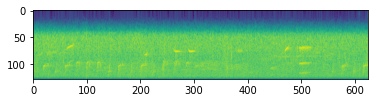

In [16]:
spectrogram_train, label_train = next(iter(dataset_train))
print(spectrogram_train.shape)
print(label_train)
plt.imshow(tf.math.log(spectrogram_train.numpy()[0, :, :, 0]));

(32, 128, 625, 1)
tf.Tensor(
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]], shape=(32, 50), dtype=float32)


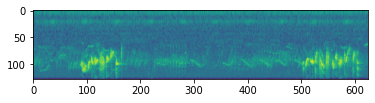

In [17]:
spectrogram_val, label_val = next(iter(dataset_val))
print(spectrogram_val.shape)
print(label_val)
plt.imshow(tf.math.log(spectrogram_val.numpy()[0, :, :, 0]));

# First model

In [18]:
def generate_model():
    
    model = models.Sequential()
    model.add(layers.Conv2D(6, kernel_size=(3, 3), activation='relu', input_shape=(128, 625, 1)))
    model.add(layers.Conv2D(4, kernel_size=(3, 3), activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(50, activation='softmax')) 
    
    model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
    
    return model

In [19]:
model = generate_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 623, 6)       60        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 124, 621, 4)       220       
_________________________________________________________________
flatten (Flatten)            (None, 308016)            0         
_________________________________________________________________
dense (Dense)                (None, 50)                15400850  
Total params: 15,401,130
Trainable params: 15,401,130
Non-trainable params: 0
_________________________________________________________________


In [20]:
es = EarlyStopping(patience=5, restore_best_weights=True)

history = model.fit(
    dataset_train,
    epochs=20,
    validation_data=dataset_val,
    callbacks=[es]
    )

Epoch 1/20
39/39 [==============================] - 915s 23s/step - loss: 16.9751 - accuracy: 0.1366 - val_loss: 6.0501 - val_accuracy: 0.2034
Epoch 2/20
39/39 [==============================] - 1s 29ms/step - loss: 0.6806 - accuracy: 0.9208 - val_loss: 5.3546 - val_accuracy: 0.2276
Epoch 3/20
39/39 [==============================] - 1s 28ms/step - loss: 0.2696 - accuracy: 0.9774 - val_loss: 7.0081 - val_accuracy: 0.1840
Epoch 4/20
39/39 [==============================] - 1s 29ms/step - loss: 0.1085 - accuracy: 0.9919 - val_loss: 8.0210 - val_accuracy: 0.2107
Epoch 5/20
39/39 [==============================] - 1s 29ms/step - loss: 0.0627 - accuracy: 0.9935 - val_loss: 7.4903 - val_accuracy: 0.2203
Epoch 6/20
39/39 [==============================] - 1s 29ms/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 8.0389 - val_accuracy: 0.2300
Epoch 7/20
39/39 [==============================] - 1s 29ms/step - loss: 0.0086 - accuracy: 1.0000 - val_loss: 8.8165 - val_accuracy: 0.2010
